In [66]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflowjs as tfjs


### Opening Dataset

In [ ]:

dataset_dir = "/Users/bimaaristo/MemeProject/dataset"

Found 165 files belonging to 4 classes.
✅ Classes found: ['bite_finger', 'holding_hand', 'open_mouth', 'static']


In [31]:
IMG_SIZE = (400, 500)
BATCH_SIZE = 32
SEED = 42

# 1️⃣ Base generator — no preprocessing, only rescaling to [0, 1]
base_datagen = ImageDataGenerator(rescale=1./255)

# Load all data first
dataset = base_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# 2️⃣ Extract paths and labels
file_paths = dataset.filepaths
labels = dataset.classes
class_names = list(dataset.class_indices.keys())

# Split into 80:10:10
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Found 165 images belonging to 4 classes.
Train: 132, Val: 16, Test: 17


In [33]:

# 3️⃣ Data augmentation (for train only)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation and Test datagen — only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(datagen, paths, labels):
    df = pd.DataFrame({
        'filename': paths,
        'class': [class_names[i] for i in labels]  # convert int → string label
    })
    return datagen.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED
    )

# 4️⃣ Create generators
train_generator = create_generator(train_datagen, train_paths, train_labels)
val_generator = create_generator(val_test_datagen, val_paths, val_labels)
test_generator = create_generator(val_test_datagen, test_paths, test_labels)

Found 132 validated image filenames belonging to 4 classes.
Found 16 validated image filenames belonging to 4 classes.
Found 17 validated image filenames belonging to 4 classes.


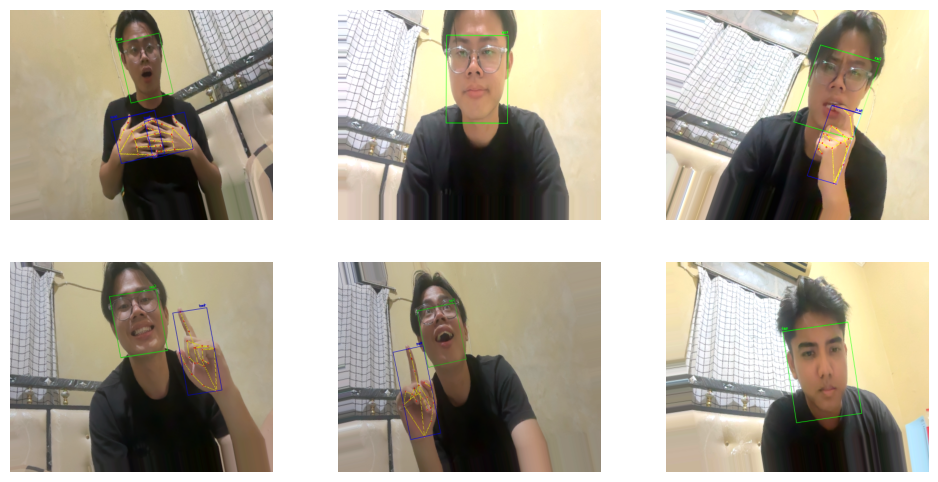

In [36]:
import matplotlib.pyplot as plt

# Take one image and see multiple augmented versions
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

In [70]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(400, 500, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [69]:
print(train_generator.image_shape)

(400, 500, 3)


In [71]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(400, 500, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 600000)            0         
                                                                 
 dense_29 (Dense)            (None, 512)               307200512 
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                     

In [73]:
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
5/5 [==============================] - 30s 1s/step - loss: 2.1984 - accuracy: 0.2652 - val_loss: 13.2637 - val_accuracy: 0.2500
Epoch 2/20
5/5 [==============================] - 5s 708ms/step - loss: 2.2768 - accuracy: 0.2576 - val_loss: 10.4087 - val_accuracy: 0.2500
Epoch 3/20
5/5 [==============================] - 5s 722ms/step - loss: 2.3406 - accuracy: 0.2121 - val_loss: 8.5050 - val_accuracy: 0.2500
Epoch 4/20
5/5 [==============================] - 5s 1s/step - loss: 2.1785 - accuracy: 0.2652 - val_loss: 7.5703 - val_accuracy: 0.2500
Epoch 5/20
5/5 [==============================] - 5s 718ms/step - loss: 2.1086 - accuracy: 0.2803 - val_loss: 6.8483 - val_accuracy: 0.2500
Epoch 6/20
5/5 [==============================] - 5s 628ms/step - loss: 1.9008 - accuracy: 0.2803 - val_loss: 6.3645 - val_accuracy: 0.2500
Epoch 7/20
5/5 [==============================] - 6s 967ms/step - loss: 1.7384 - accuracy: 0.2879 - val_loss: 5.9868 - val_accuracy: 0.2500
Epoch 8/20
5/5 [=======

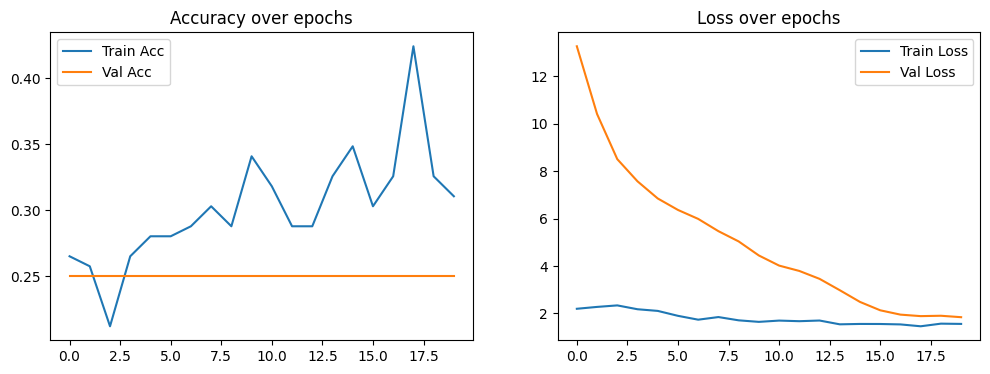

In [74]:

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over epochs')

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')

plt.show()

In [ ]:

# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomBrightness(factor=0.2),
#     layers.RandomContrast(0.2),
# ])

In [24]:
def augment_to_1000(dataset, class_names, target_count=1000):
    """
    Augments a TensorFlow dataset to have 'target_count' samples per class efficiently.
    """
    # Step 1: Create dict to store images per class
    class_dict = {name: [] for name in class_names}

    # Step 2: Populate dictionary
    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = class_names[int(label)]
            class_dict[class_name].append(img)

    # Step 3: Augment until each class reaches target_count
    for class_name, imgs in class_dict.items():
        print(f"Processing class '{class_name}' ({len(imgs)} base images)...")
        while len(imgs) < target_count:
            # Pick a random image and augment it
            idx = np.random.randint(0, len(imgs))
            aug_img = data_augmentation(tf.expand_dims(imgs[idx], 0))[0]
            imgs.append(aug_img)
        class_dict[class_name] = imgs[:target_count]  # Trim to exact count

        print(f"✅ Class '{class_name}' now has {len(imgs)} samples.")

    # Step 4: Combine all classes back into tensors
    all_images = []
    all_labels = []
    for label_idx, class_name in enumerate(class_names):
        all_images.extend(class_dict[class_name])
        all_labels.extend([label_idx] * len(class_dict[class_name]))

    # Step 5: Create final TensorFlow dataset
    final_ds = tf.data.Dataset.from_tensor_slices((tf.stack(all_images), tf.constant(all_labels)))
    return final_ds.shuffle(1000).batch(32)

In [29]:
augmented_ds = augment_to_1000(dataset, class_names, target_count=1000)

Processing class 'bite_finger' (41 base images)...
✅ Class 'bite_finger' now has 1000 samples.
Processing class 'holding_hand' (42 base images)...
✅ Class 'holding_hand' now has 1000 samples.
Processing class 'open_mouth' (41 base images)...
✅ Class 'open_mouth' now has 1000 samples.
Processing class 'static' (41 base images)...
✅ Class 'static' now has 1000 samples.


2025-10-21 00:37:59.106428: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 17179869184
2025-10-21 00:37:59.112779: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 17179869184
2025-10-21 00:38:09.146068: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 17179869184
2025-10-21 00:38:09.149975: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 17179869184
2025-10-21 00:38:09.168645: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (pluggable_device_host_bfc) ran out of memory trying to allocate 8.94GiB (rounded to 9600000000)requested by op Pack
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary

ResourceExhaustedError: {{function_node __wrapped__Pack_N_4000_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4000,400,500,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator pluggable_device_host_bfc
	 [[{{node Pack}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:Pack] name: stack